In [117]:
#Set up and import the modules, and separate the data into train test groups

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from datasets import load_dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter


dataset = load_dataset("aai510-group1/telco-customer-churn")
train = dataset['train'].to_pandas()
test = dataset['test'].to_pandas()
ytrain = train['Churn Category']
ytest = test['Churn Category']
xtrain = train.drop(
    columns= ['Churn', 'City', 'Churn Reason', 'Churn Category',
              'Churn Score', 'Country', 'Customer ID', 'Internet Service',
              'State', 'Lat Long', 'Latitude', 'Longitude', 'Partner',
              'Customer Status', 'Quarter', 'Total Revenue', 'Zip Code'],
    axis = 1)
xtest = test.drop(
    columns= ['Churn', 'City', 'Churn Reason', 'Churn Category',
              'Churn Score', 'Country', 'Customer ID', 'Internet Service',
              'State', 'Lat Long', 'Latitude', 'Longitude', 'Partner',
              'Customer Status', 'Quarter', 'Total Revenue', 'Zip Code'],
    axis = 1)


In [118]:
#Handle missing values and convert categorical values to categorical dummies

ytrain.fillna('No Churn', inplace= True)
ytest.fillna('No Churn', inplace= True)
xtrain['Offer'].fillna('No Offer', inplace= True)
xtest['Offer'].fillna('No Offer', inplace= True)
xtrain['Internet Type'].fillna('No Internet', inplace= True)
xtest['Internet Type'].fillna('No Internet', inplace= True)
xtrain = pd.get_dummies(xtrain, 
                        columns= ['Contract', 'Gender', 'Internet Type', 'Offer', 'Payment Method'],
                        drop_first= True).astype(int)
xtest = pd.get_dummies(xtest, 
                       columns= ['Contract', 'Gender', 'Internet Type', 'Offer', 'Payment Method'],
                       drop_first= True).astype(int)

/var/folders/2y/j58yz6jx1knf5g018pf46x740000gn/T/ipykernel_9802/857740790.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  xtrain['Offer'].fillna('No Offer', inplace= True)
/var/folders/2y/j58yz6jx1knf5g018pf46x740000gn/T/ipykernel_9802/857740790.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [119]:
#Utilize correlation values to check for overlooked derived or redundant information features 

correlations = xtrain.corr().unstack()
correlations = correlations[correlations.index.get_level_values(0) != correlations.index.get_level_values(1)]
correlations = correlations.abs().sort_values(ascending=False)
correlation_df = correlations.reset_index()
correlation_df.columns = ['Feature 1', 'Feature 2', 'Correlation']
print(correlation_df.head(20))

                      Feature 1                    Feature 2  Correlation
0                       Married            Referred a Friend     0.954064
1             Referred a Friend                      Married     0.954064
2                    Dependents         Number of Dependents     0.891212
3          Number of Dependents                   Dependents     0.891212
4               Streaming Music             Streaming Movies     0.846870
5              Streaming Movies              Streaming Music     0.846870
6              Tenure in Months                Total Charges     0.825726
7                 Total Charges             Tenure in Months     0.825726
8                Monthly Charge    Internet Type_Fiber Optic     0.776884
9     Internet Type_Fiber Optic               Monthly Charge     0.776884
10               Monthly Charge    Internet Type_No Internet     0.754665
11    Internet Type_No Internet               Monthly Charge     0.754665
12               Unlimited Data    Int

In [120]:
#Convert streaming service type dummies to a single streaming service count variable for better interpretation.
#Cancel redundant or derived features based on the correlation values.

xtrain['Streaming Service Count'] = xtrain['Streaming TV'] + xtrain['Streaming Music'] + xtrain['Streaming Movies']
xtrain.drop(columns= ['Referred a Friend', 'Number of Dependents', 'Senior Citizen', 
                      'Under 30', 'Streaming Music', 'Streaming Movies', 'Streaming TV', 
                      'Total Charges', 'Total Long Distance Charges', 'Unlimited Data', 
                      'Monthly Charge'], inplace= True)
xtest['Streaming Service Count'] = xtest['Streaming TV'] + xtest['Streaming Music'] + xtest['Streaming Movies']
xtest.drop(columns= ['Referred a Friend', 'Number of Dependents', 'Senior Citizen', 
                      'Under 30', 'Streaming Music', 'Streaming Movies', 'Streaming TV', 
                      'Total Charges', 'Total Long Distance Charges', 'Unlimited Data', 
                      'Monthly Charge'], inplace= True)

In [121]:
#Find Variance Inflation Factors for each features to identify multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_df = pd.DataFrame()
vif_df['Features'] = xtrain.columns
vif_df['VIF'] = [round(variance_inflation_factor(xtrain.values, i),2) for i in range(len(xtrain.columns))]
print(vif_df)

                             Features    VIF
0                                 Age   9.05
1             Avg Monthly GB Download   3.40
2   Avg Monthly Long Distance Charges   4.13
3                                CLTV  15.15
4                          Dependents   1.66
5              Device Protection Plan   2.25
6                             Married   4.04
7                      Multiple Lines   2.45
8                 Number of Referrals   2.78
9                       Online Backup   2.14
10                    Online Security   2.03
11                  Paperless Billing   2.89
12                      Phone Service  15.39
13                         Population   2.08
14               Premium Tech Support   2.09
15                 Satisfaction Score   9.19
16                   Tenure in Months   9.93
17           Total Extra Data Charges   1.12
18                      Total Refunds   1.08
19                  Contract_One Year   2.03
20                  Contract_Two Year   3.19
21        

In [122]:
xtrain.drop(columns= ['CLTV', 'Phone Service'], inplace= True)
xtest.drop(columns= ['CLTV', 'Phone Service'], inplace= True)

In [123]:
from sklearn.linear_model import LogisticRegression
logreg_l1 = LogisticRegression(
    penalty='l1',
    C=0.3,             
    solver='saga',
    multi_class='multinomial',
    max_iter=1000,
    random_state=42
)
logreg_l1.fit(xtrain, ytrain)
coef_matrix = logreg_l1.coef_
feature_names = xtrain.columns
feature_importance = abs(coef_matrix).sum(axis = 0)
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by= 'Importance', ascending= False)
print(feature_df)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                              Feature  Importance
14                   Tenure in Months    0.016398
0                                 Age    0.014813
2   Avg Monthly Long Distance Charges    0.007718
1             Avg Monthly GB Download    0.006175
15           Total Extra Data Charges    0.001914
13                 Satisfaction Score    0.001749
7                 Number of Referrals    0.001266
16                      Total Refunds    0.000778
30            Streaming Service Count    0.000307
5                             Married    0.000211
28         Payment Method_Credit Card    0.000205
18                  Contract_Two Year    0.000182
19                        Gender_Male    0.000177
3                          Dependents    0.000152
9                     Online Security    0.000149
12               Premium Tech Support    0.000147
8                       Online Backup    0.000139
22          Internet Type_No Internet    0.000139
10                  Paperless Billing    0.000135


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [124]:
max_importance = feature_df['Importance'].max()
threshold = 0.01 * max_importance
low_importance = feature_df[feature_df['Importance'] < threshold]['Feature']
xtrain.drop(columns= low_importance, inplace = True)
xtest.drop(columns= low_importance, inplace = True)

In [125]:
xtrain.columns

Index(['Age', 'Avg Monthly GB Download', 'Avg Monthly Long Distance Charges',
       'Married', 'Number of Referrals', 'Satisfaction Score',
       'Tenure in Months', 'Total Extra Data Charges', 'Total Refunds',
       'Contract_Two Year', 'Gender_Male', 'Payment Method_Credit Card',
       'Streaming Service Count'],
      dtype='object')

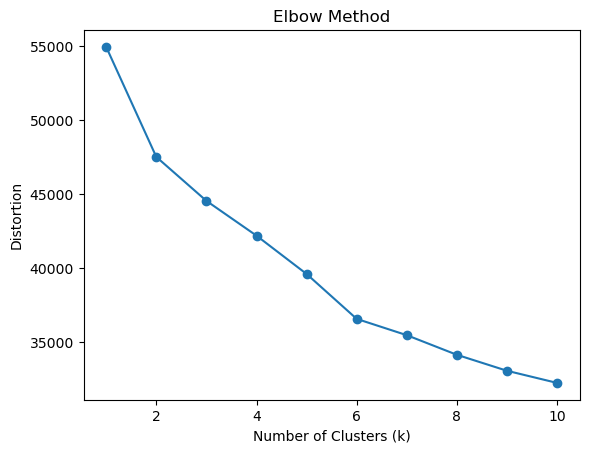

In [126]:

scaler = StandardScaler()
xscaled = xtrain.copy()
xscaled = scaler.fit_transform(xtrain)

distortions = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(xscaled)
    distortions.append(kmeans.inertia_)

plt.plot(k_values, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


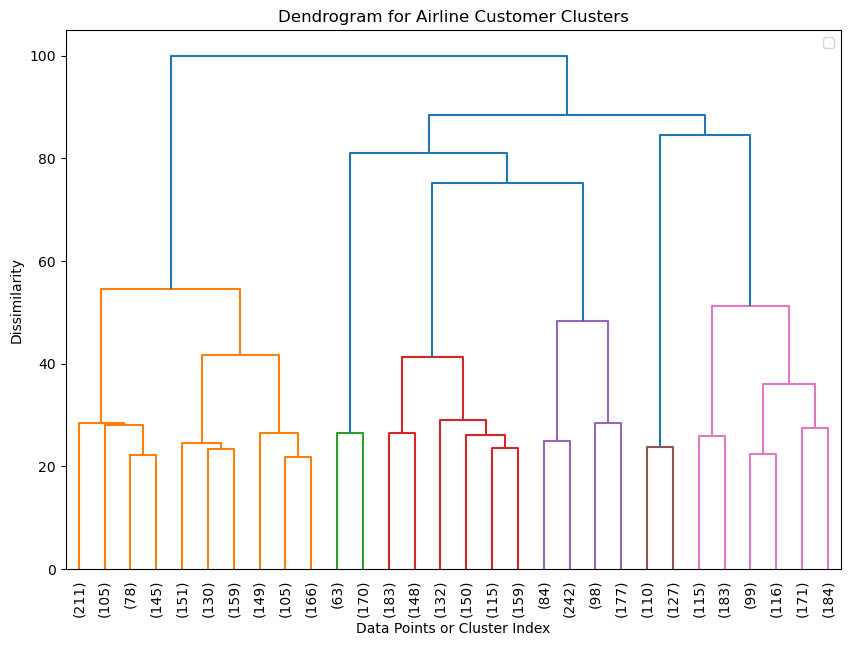

In [127]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
linkage_matrix = linkage(xscaled, method='ward')  # Ward's method minimizes variance within clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrogram for Airline Customer Clusters')
plt.xlabel('Data Points or Cluster Index')
plt.ylabel('Dissimilarity')
plt.legend()
plt.show()

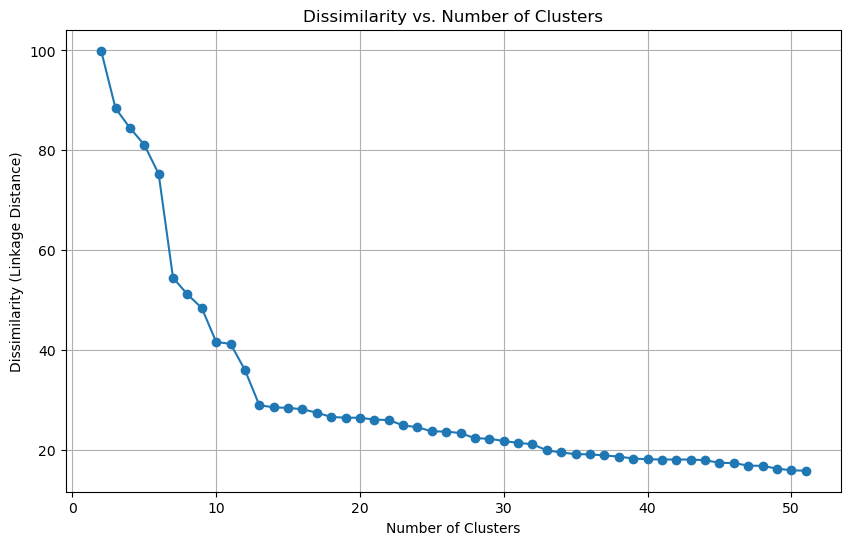

In [128]:
from scipy.cluster.hierarchy import linkage
import numpy as np

linkage_matrix = linkage(xscaled, method='ward')
linkage_distances = linkage_matrix[-50:, 2]
num_clusters = np.arange(51, 1, -1)

plt.figure(figsize=(10, 6))
plt.plot(num_clusters, linkage_distances, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Dissimilarity (Linkage Distance)')
plt.title('Dissimilarity vs. Number of Clusters')
plt.grid()
plt.show()


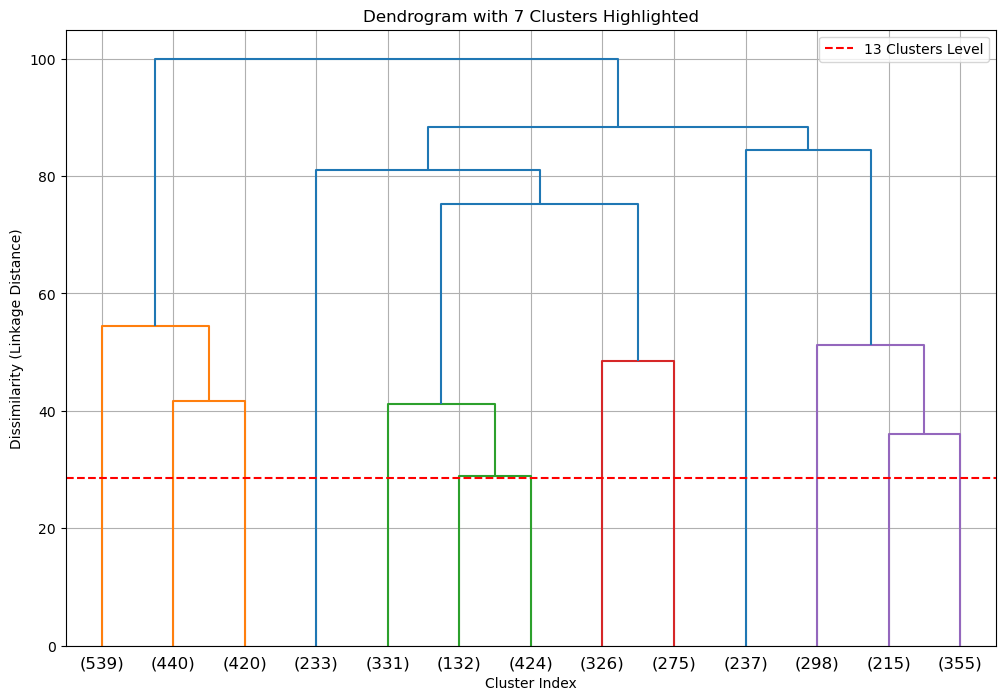

In [129]:
dissimilarity_level = linkage_matrix[-13, 2]

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=13, show_leaf_counts=True)
plt.axhline(y=dissimilarity_level, color='r', linestyle='--', label='13 Clusters Level')
plt.title('Dendrogram with 7 Clusters Highlighted')
plt.xlabel('Cluster Index')
plt.ylabel('Dissimilarity (Linkage Distance)')
plt.legend()
plt.grid()
plt.show()

In [130]:
optimal_clusters = 13
linkage_matrix = linkage(xtrain, method='ward')
train_cluster_labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')

cluster_centroids = np.array([xtrain[train_cluster_labels == cluster].mean(axis=0) 
                               for cluster in range(1, optimal_clusters + 1)])

test_cluster_labels = np.argmin(cdist(xtest, cluster_centroids), axis=1) + 1 

In [131]:
categories = ytrain.unique()
most_frequent_class = categories[np.argmax([ytrain[ytrain == cat].count() for cat in categories])]
y_pred_baseline = [most_frequent_class] * len(ytest)
baseline_accuracy = accuracy_score(ytest, y_pred_baseline)
print(f"Baseline Model Test Accuracy (Overall): {baseline_accuracy:.4f}")

Baseline Model Test Accuracy (Overall): 0.7346


In [132]:
models = {}
cluster_metrics = {}
y_pred_total = np.zeros_like(ytest)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
for cluster in range(1, optimal_clusters + 1):
    X_train_cluster = xtrain.iloc[np.where(train_cluster_labels == cluster)[0]]
    y_train_cluster = ytrain.iloc[np.where(train_cluster_labels == cluster)[0]]
    indices = np.where(test_cluster_labels == cluster)[0]  
    X_test_cluster = xtest.iloc[indices]
    y_test_cluster = ytest.iloc[indices]

    model = LinearDiscriminantAnalysis()
    model.fit(X_train_cluster, y_train_cluster)
    y_pred_cluster = model.predict(X_test_cluster)
    y_pred_total[indices] = y_pred_cluster 
    accuracy = accuracy_score(y_test_cluster, y_pred_cluster)

    models[cluster] = model
    cluster_metrics[cluster] = accuracy

overall_accuracy1 = accuracy_score(ytest, y_pred_total)
for cluster, accuracy in cluster_metrics.items():
    print(f"Cluster {cluster}: Accuracy = {accuracy:.2f}")
print("\nOverall Metrics:")
print(f"Overall Accuracy: {overall_accuracy1:.2f}")

Cluster 1: Accuracy = 0.75
Cluster 2: Accuracy = 0.75
Cluster 3: Accuracy = 0.92
Cluster 4: Accuracy = 0.70
Cluster 5: Accuracy = 0.82
Cluster 6: Accuracy = 0.69
Cluster 7: Accuracy = 0.70
Cluster 8: Accuracy = 0.91
Cluster 9: Accuracy = 0.94
Cluster 10: Accuracy = 0.88
Cluster 11: Accuracy = 0.90
Cluster 12: Accuracy = 0.94
Cluster 13: Accuracy = 0.83

Overall Metrics:
Overall Accuracy: 0.81


In [133]:
models = {}
cluster_metrics = {}
y_pred_total = np.zeros_like(ytest)
ccp = np.linspace(0, 0.10, 200) 
param_grid = {
    'ccp_alpha': ccp,
    'min_samples_leaf': [5]
}

for cluster in range(1, optimal_clusters + 1):
    X_train_cluster = xtrain.iloc[np.where(train_cluster_labels == cluster)[0]]
    y_train_cluster = ytrain.iloc[np.where(train_cluster_labels == cluster)[0]]

    indices = np.where(test_cluster_labels == cluster)[0] 
    X_test_cluster = xtest.iloc[indices]
    y_test_cluster = ytest.iloc[indices]

    tree = DecisionTreeClassifier(random_state=2024)
    grid_search = GridSearchCV(tree, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    grid_search.fit(X_train_cluster, y_train_cluster)

    best_model = grid_search.best_estimator_
    y_pred_cluster = best_model.predict(X_test_cluster)
    y_pred_total[indices] = y_pred_cluster 

    accuracy = accuracy_score(y_test_cluster, y_pred_cluster)
    models[cluster] = best_model
    cluster_metrics[cluster] = accuracy

overall_accuracy2 = accuracy_score(ytest, y_pred_total)
for cluster, accuracy in cluster_metrics.items():
    print(f"Cluster {cluster}: Accuracy = {accuracy:.2f}")
print("\nOverall Metrics:")
print(f"Overall Accuracy: {overall_accuracy2:.2f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python

Cluster 1: Accuracy = 0.78
Cluster 2: Accuracy = 0.83
Cluster 3: Accuracy = 0.95
Cluster 4: Accuracy = 0.72
Cluster 5: Accuracy = 0.82
Cluster 6: Accuracy = 0.70
Cluster 7: Accuracy = 0.73
Cluster 8: Accuracy = 0.92
Cluster 9: Accuracy = 0.95
Cluster 10: Accuracy = 0.91
Cluster 11: Accuracy = 0.91
Cluster 12: Accuracy = 0.96
Cluster 13: Accuracy = 0.86

Overall Metrics:
Overall Accuracy: 0.83


In [134]:
models = {}
cluster_metrics = {}
y_pred_total = np.zeros_like(ytest) 

for cluster in range(1, optimal_clusters + 1):
    X_train_cluster = xtrain.iloc[np.where(train_cluster_labels == cluster)[0]]
    y_train_cluster = ytrain.iloc[np.where(train_cluster_labels == cluster)[0]]
    indices = np.where(test_cluster_labels == cluster)[0] 
    X_test_cluster = xtest.iloc[indices]
    y_test_cluster = ytest.iloc[indices]

    rf_model = RandomForestClassifier(random_state=42)
    cross_val_scores_rf = cross_val_score(rf_model, X_train_cluster, y_train_cluster, cv=5, scoring='accuracy')
    rf_model.fit(X_train_cluster, y_train_cluster)
    y_pred_cluster = rf_model.predict(X_test_cluster)
    y_pred_total[indices] = y_pred_cluster
    accuracy = accuracy_score(y_test_cluster, y_pred_cluster)

    models[cluster] = rf_model
    cluster_metrics[cluster] = {
        'accuracy': accuracy,
        'cv_mean_accuracy': cross_val_scores_rf.mean()
    }

overall_accuracy3 = accuracy_score(ytest, y_pred_total)
for cluster, metrics in cluster_metrics.items():
    print(f"Cluster {cluster}:")
    print(f"  Test Accuracy: {metrics['accuracy']:.2f}")
    print(f"  CV Mean Accuracy: {metrics['cv_mean_accuracy']:.2f}")
print("\nOverall Metrics:")
print(f"Overall Accuracy: {overall_accuracy3:.2f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python

Cluster 1:
  Test Accuracy: 0.78
  CV Mean Accuracy: 0.82
Cluster 2:
  Test Accuracy: 0.78
  CV Mean Accuracy: 0.81
Cluster 3:
  Test Accuracy: 0.92
  CV Mean Accuracy: 0.93
Cluster 4:
  Test Accuracy: 0.71
  CV Mean Accuracy: 0.79
Cluster 5:
  Test Accuracy: 0.82
  CV Mean Accuracy: 0.76
Cluster 6:
  Test Accuracy: 0.68
  CV Mean Accuracy: 0.65
Cluster 7:
  Test Accuracy: 0.72
  CV Mean Accuracy: 0.74
Cluster 8:
  Test Accuracy: 0.93
  CV Mean Accuracy: 0.89
Cluster 9:
  Test Accuracy: 0.94
  CV Mean Accuracy: 0.91
Cluster 10:
  Test Accuracy: 0.88
  CV Mean Accuracy: 0.89
Cluster 11:
  Test Accuracy: 0.90
  CV Mean Accuracy: 0.84
Cluster 12:
  Test Accuracy: 0.96
  CV Mean Accuracy: 0.97
Cluster 13:
  Test Accuracy: 0.86
  CV Mean Accuracy: 0.89

Overall Metrics:
Overall Accuracy: 0.82


In [135]:
models = {}
cluster_metrics = {}
y_pred_total = np.zeros_like(ytest)

for cluster in range(1, optimal_clusters + 1):
    X_train_cluster = xtrain.iloc[np.where(train_cluster_labels == cluster)[0]]
    y_train_cluster = ytrain.iloc[np.where(train_cluster_labels == cluster)[0]]

    indices = np.where(test_cluster_labels == cluster)[0]
    X_test_cluster = xtest.iloc[indices]
    y_test_cluster = ytest.iloc[indices]

    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train_cluster, y_train_cluster)
    y_pred_cluster = gb_model.predict(X_test_cluster)
    y_pred_total[indices] = y_pred_cluster 
    accuracy = accuracy_score(y_test_cluster, y_pred_cluster)
    models[cluster] = gb_model
    cluster_metrics[cluster] = accuracy

overall_accuracy4 = accuracy_score(ytest, y_pred_total)
for cluster, accuracy in cluster_metrics.items():
    print(f"Cluster {cluster}: Accuracy = {accuracy:.2f}")

print("\nOverall Metrics:")
print(f"Overall Accuracy: {overall_accuracy4:.2f}")

Cluster 1: Accuracy = 0.75
Cluster 2: Accuracy = 0.72
Cluster 3: Accuracy = 0.93
Cluster 4: Accuracy = 0.70
Cluster 5: Accuracy = 0.79
Cluster 6: Accuracy = 0.65
Cluster 7: Accuracy = 0.70
Cluster 8: Accuracy = 0.93
Cluster 9: Accuracy = 0.92
Cluster 10: Accuracy = 0.88
Cluster 11: Accuracy = 0.90
Cluster 12: Accuracy = 0.95
Cluster 13: Accuracy = 0.83

Overall Metrics:
Overall Accuracy: 0.80


/var/folders/2y/j58yz6jx1knf5g018pf46x740000gn/T/ipykernel_9802/5588336.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc_df, x='Models', y='Accuracy', palette='viridis')


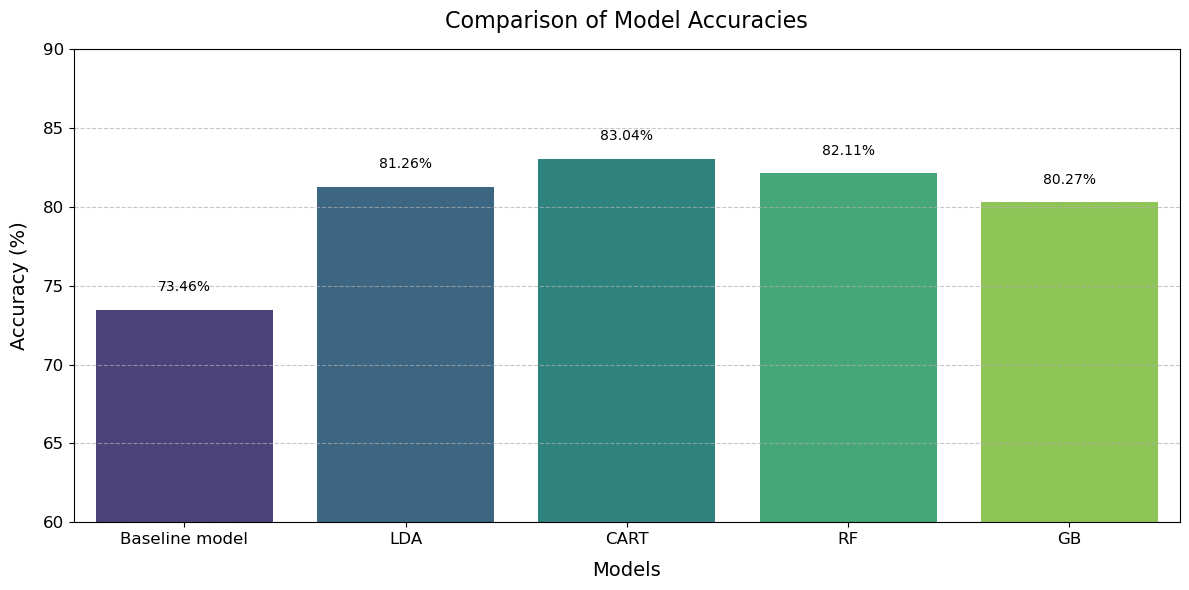

In [ ]:
column_name = ['Baseline model', 'LDA', 'CART', 'RF', 'GB']
accuracy_all = [100*i for i in [baseline_accuracy, overall_accuracy1, 
                overall_accuracy2, overall_accuracy3, 
                overall_accuracy4]]
acc_df = pd.DataFrame({'Models': column_name, 
                       'Accuracy': accuracy_all})

plt.figure(figsize=(12, 6))
sns.barplot(data=acc_df, x='Models', y='Accuracy', palette='viridis')

for index, value in enumerate(accuracy_all):
    plt.text(index, value + 1, f"{value:.2f}%", ha='center', va='bottom', fontsize=10)

plt.ylim(min(60, min(accuracy_all) - 5), 90)
plt.xlabel('Models', fontsize=14, labelpad=10)
plt.ylabel('Accuracy (%)', fontsize=14, labelpad=10)
plt.title('Comparison of Model Accuracies', fontsize=16, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()